## Import TensorFlow and other libraries

In [1]:
! nvidia-smi

Sat Feb 22 17:09:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.14                 Driver Version: 566.14         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   42C    P0             14W /   79W |       0MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
if tf.test.is_gpu_available():
    print("GPU is available")
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Version:  2.18.0
Eager mode:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Please install GPU version of TF


In [29]:
# from google.colab import drive
# drive.mount('/content/drive')

## Download and explore the dataset

In [4]:
data_root='D:/CNN-With/data/'
import pathlib
data_dir = pathlib.Path(data_root)
print(f"data_dir: {data_dir}")

data_dir: D:\CNN-With\data


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')) + list(data_dir.glob('*/*.jpeg')))
print(image_count)

9059


# Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

## Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 224
img_width = 224

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9059 files belonging to 7 classes.
Using 7248 files for training.


In [8]:
import tensorflow as tf
import numpy as np

# Assuming 'train_ds' is already defined (using 'image_dataset_from_directory')
class_counts = {}

# Iterate through the dataset
for images, labels in train_ds:
    # Convert the labels to numpy array (if not already) and flatten
    labels = labels.numpy().flatten()
    
    # Count the occurrences of each label (class index)
    for label in labels:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1

# Print out the class counts
for class_index, count in class_counts.items():
    print(f"Class index {class_index} has {count} images")
    
# Optionally, if you want to print out the class names (assuming you know the order of classes)
class_names = train_ds.class_names  # This will give the class names
for class_index, count in class_counts.items():
    print(f"Class '{class_names[class_index]}' has {count} images")

Class index 2 has 1066 images
Class index 0 has 1339 images
Class index 5 has 1145 images
Class index 6 has 754 images
Class index 3 has 1177 images
Class index 4 has 971 images
Class index 1 has 796 images
Class 'MDMV' has 1066 images
Class 'CDM' has 1339 images
Class 'SCMV' has 1145 images
Class 'SR' has 754 images
Class 'NCLB' has 1177 images
Class 'SCLB' has 971 images
Class 'HT' has 796 images


In [9]:
import numpy as np
from sklearn.utils import class_weight

# Get the class names from the dataset
class_names = train_ds.class_names

# Initialize a list to store the labels
all_labels = []

# Iterate through the dataset to gather all labels
for images, labels in train_ds:
    all_labels.extend(labels.numpy())

# Compute class weights based on the label distribution
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),  # class indices (0, 1, 2, ...)
    y=all_labels  # Flattened list of labels
)

# Convert the class weights to a dictionary
class_weight_dict = dict(zip(np.arange(len(class_names)), class_weights))

# Print the class weights for each class
for i, class_name in enumerate(class_names):
    print(f"Class '{class_name}' has weight: {class_weight_dict[i]}")

Class 'CDM' has weight: 0.7732849674597247
Class 'HT' has weight: 1.3007896625987079
Class 'MDMV' has weight: 0.971321361565264
Class 'NCLB' has weight: 0.8797184124286928
Class 'SCLB' has weight: 1.0663528027070766
Class 'SCMV' has weight: 0.9043044291952589
Class 'SR' has weight: 1.3732474422129595


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9059 files belonging to 7 classes.
Using 1811 files for validation.


In [11]:
import tensorflow as tf
import numpy as np

# Assuming 'train_ds' is already defined (using 'image_dataset_from_directory')
class_counts = {}

# Iterate through the dataset
for images, labels in val_ds:
    # Convert the labels to numpy array (if not already) and flatten
    labels = labels.numpy().flatten()
    
    # Count the occurrences of each label (class index)
    for label in labels:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1

# Print out the class counts
for class_index, count in class_counts.items():
    print(f"Class index {class_index} has {count} images")
    
# Optionally, if you want to print out the class names (assuming you know the order of classes)
class_names = train_ds.class_names  # This will give the class names
for class_index, count in class_counts.items():
    print(f"Class '{class_names[class_index]}' has {count} images")

Class index 0 has 342 images
Class index 5 has 291 images
Class index 3 has 304 images
Class index 4 has 219 images
Class index 1 has 214 images
Class index 2 has 256 images
Class index 6 has 185 images
Class 'CDM' has 342 images
Class 'SCMV' has 291 images
Class 'NCLB' has 304 images
Class 'SCLB' has 219 images
Class 'HT' has 214 images
Class 'MDMV' has 256 images
Class 'SR' has 185 images


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [12]:
class_names = train_ds.class_names
print(class_names)

['CDM', 'HT', 'MDMV', 'NCLB', 'SCLB', 'SCMV', 'SR']


## Visualize the data

Here are the first nine images from the training dataset:

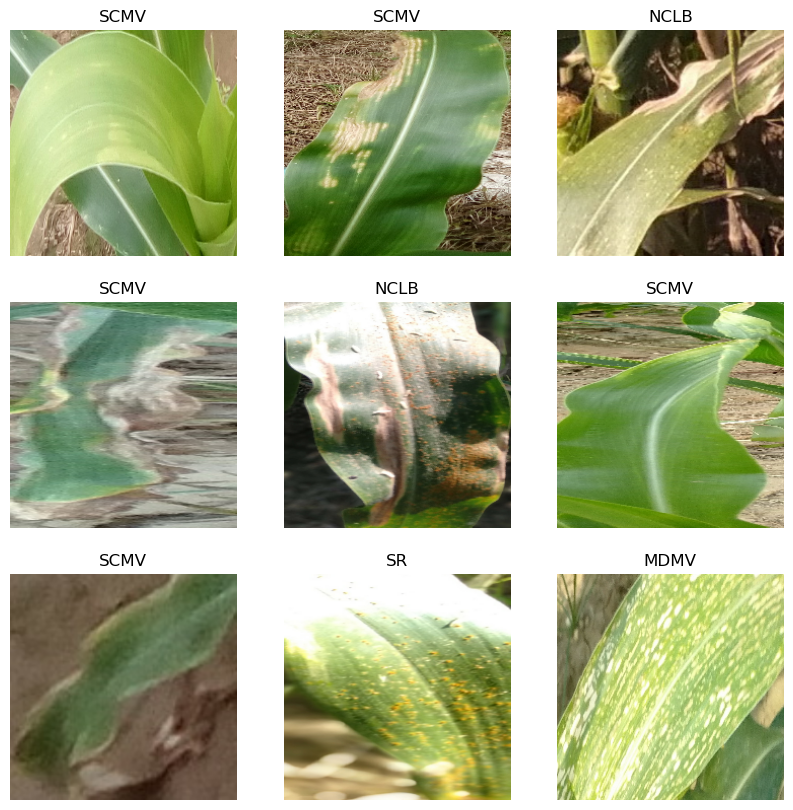

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to `Model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [16]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

# Create the model

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy—the goal of this tutorial is to show a standard approach.

In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  # layers.Dense(num_classes)
  layers.Dense(num_classes, activation='softmax')
])

c:\Users\somnu\anaconda3\envs\deep\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [19]:
# model.compile(optimizer='adam',
#             #   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#               metrics=['accuracy']
#               # metrics=['accuracy']
#               )

from tensorflow.keras.optimizers import Adam

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,  # Number of steps before the learning rate decays
    decay_rate=0.9,  # Rate of decay
    staircase=True)  # If True, the learning rate will decay in discrete intervals

model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

## Model summary

View all the layers of the network using the model's `Model.summary` method:

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,447,143 (24.59 MB)

 Trainable params: 6,447,143 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [21]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  class_weight=class_weight_dict
)

Epoch 1/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 24s 100ms/step - accuracy: 0.3282 - loss: 1.8531 - val_accuracy: 0.7598 - val_loss: 0.6795
Epoch 2/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - accuracy: 0.8491 - loss: 0.3915 - val_accuracy: 0.9591 - val_loss: 0.1352
Epoch 3/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - accuracy: 0.9721 - loss: 0.0916 - val_accuracy: 0.9912 - val_loss: 0.0419
Epoch 4/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9960 - loss: 0.0206 - val_accuracy: 0.9873 - val_loss: 0.0362
Epoch 5/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9981 - loss: 0.0125 - val_accuracy: 0.8907 - val_loss: 0.3553
Epoch 6/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.9778 - loss: 0.0551 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 7/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 1.0000 - loss: 5.3968e-04 - val_accuracy: 1.0000 - val_loss: 4.9711e-04
Epoch 8/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 1.0000 - loss: 

## Visualize training results

Create plots of loss and accuracy on the training and validation sets:

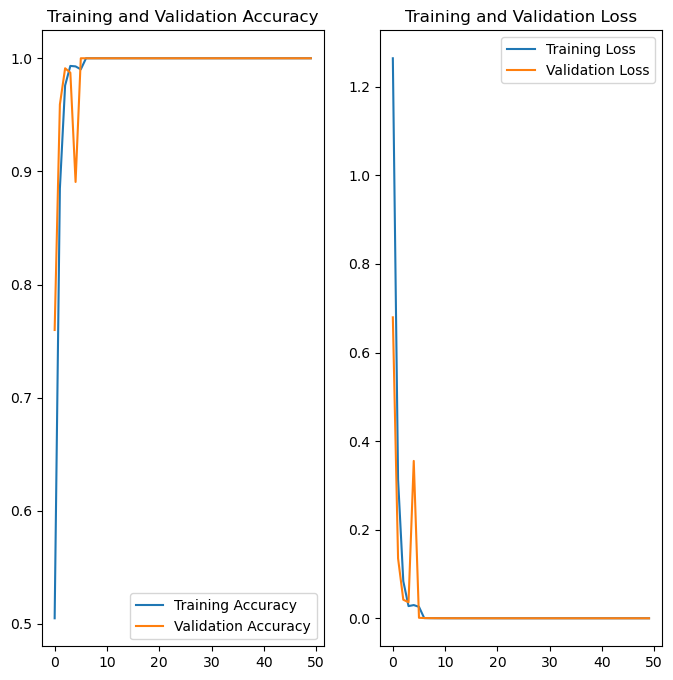

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

Let's inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *Dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

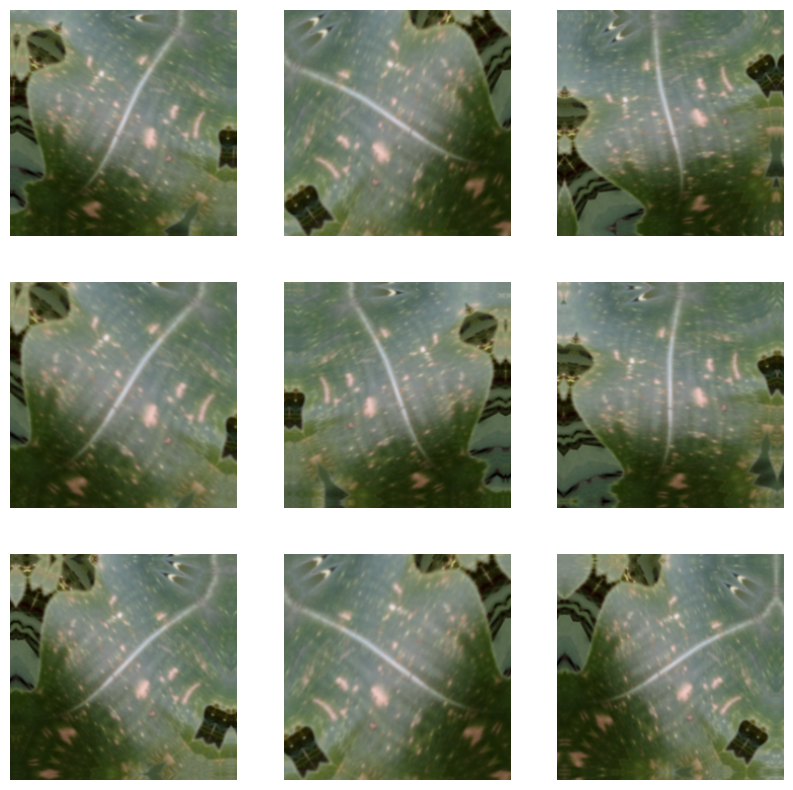

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [25]:
model = Sequential([
  # data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

## Compile and train the model

In [26]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#               metrics=['accuracy'])

from tensorflow.keras.optimizers import Adam

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,  # Number of steps before the learning rate decays
    decay_rate=0.9,  # Rate of decay
    staircase=True)  # If True, the learning rate will decay in discrete intervals

model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
epochs = 50
# history = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs
# )

try:
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=1, class_weight=class_weight_dict)
except Exception as e:
    print(f"Error occurred: {e}")

Epoch 1/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 42s 179ms/step - accuracy: 0.3157 - loss: 1.6649 - val_accuracy: 0.5605 - val_loss: 1.1773
Epoch 2/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 41s 179ms/step - accuracy: 0.5903 - loss: 1.0477 - val_accuracy: 0.7151 - val_loss: 0.8463
Epoch 3/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - accuracy: 0.7234 - loss: 0.7451 - val_accuracy: 0.7642 - val_loss: 0.6279
Epoch 4/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step - accuracy: 0.7745 - loss: 0.5765 - val_accuracy: 0.8537 - val_loss: 0.4231
Epoch 5/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - accuracy: 0.8298 - loss: 0.4441 - val_accuracy: 0.8625 - val_loss: 0.4165
Epoch 6/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - accuracy: 0.8608 - loss: 0.3733 - val_accuracy: 0.8504 - val_loss: 0.4372
Epoch 7/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 41s 179ms/step - accuracy: 0.8854 - loss: 0.2946 - val_accuracy: 0.8912 - val_loss: 0.3275
Epoch 8/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - accuracy: 0.9166 - loss: 0

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

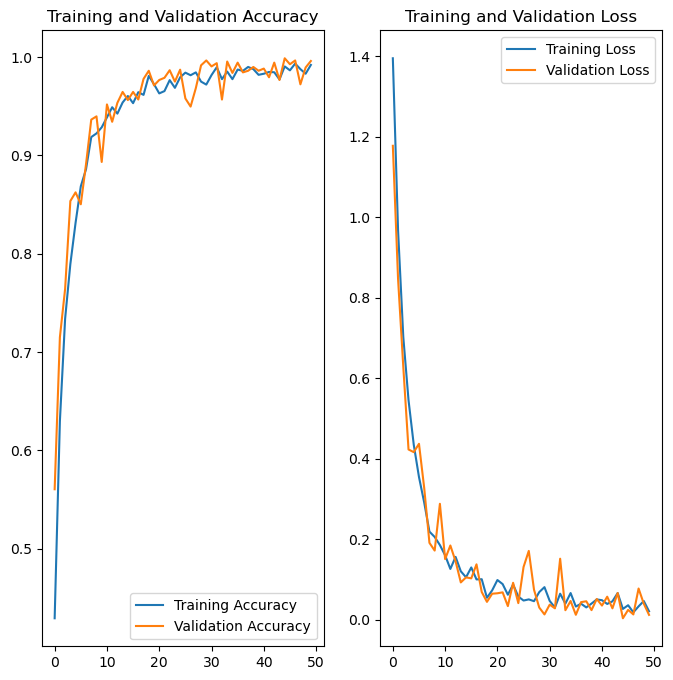

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [43]:
# Define the path to save the model
saved_model_path = "D:/CNN-With/Trained_Model_Cnn/"

# Ensure the directory exists
if not os.path.exists(saved_model_path):
    os.makedirs(saved_model_path)

# Save the model in H5 format (Keras format)
model.save(saved_model_path + "model.h5")

print(f"Model saved successfully to {saved_model_path}")

Model saved successfully to D:/CNN-With/Trained_Model_Cnn/


**Load TensorFlow SavedModel**

In [44]:
# saved_model_path = "/content/drive/MyDrive/Trained_Model_Cnn"
# model_cnn = hub.load(saved_model_path)
# print(model)

import tensorflow as tf

# Define the path where the model is saved (in H5 format)
saved_model_path = "D:/CNN-With/Trained_Model_Cnn/model.h5"

# Load the model using tf.keras.models.load_model()
model = tf.keras.models.load_model(saved_model_path)

# Print the model summary to verify it's loaded correctly
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,447,144 (24.59 MB)

 Trainable params: 6,447,143 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1 (8.00 B)

In [45]:
val_image_batch, val_label_batch = next(iter(val_ds))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [46]:
import tensorflow as tf
import pandas as pd

# Assuming model and class_names are already defined

# Get the predictions from the model
tf_model_predictions = model.predict(val_image_batch)

# If the model has logits as output (from_logits=True in loss), apply softmax to get probabilities
if 'from_logits' in model.loss.get_config() and model.loss.get_config()['from_logits']:
    tf_model_predictions = tf.nn.softmax(tf_model_predictions).numpy()

# Convert predictions to a DataFrame
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)

# Set the DataFrame columns to class names
tf_pred_dataframe.columns = class_names

# Print the first few predictions to check
print("Prediction results for the first elements")
print(tf_pred_dataframe.head())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Prediction results for the first elements
            CDM            HT          MDMV          NCLB          SCLB  \
0  4.930961e-14  3.659690e-23  1.000000e+00  1.095081e-15  1.052112e-09   
1  9.281931e-05  1.457613e-08  9.896436e-01  1.089403e-08  9.803834e-08   
2  4.913260e-15  2.589673e-12  1.124945e-08  3.233736e-05  1.389985e-05   
3  7.463230e-09  1.159719e-16  9.996647e-01  8.554466e-07  3.341983e-04   
4  2.231280e-10  3.117372e-04  5.043847e-14  9.996879e-01  1.467904e-08   

           SCMV            SR  
0  6.136366e-10  2.127548e-24  
1  1.026339e-02  2.313005e-13  
2  7.146046e-09  9.999537e-01  
3  3.356516e-07  2.936422e-13  
4  3.790914e-07  1.826256e-09  


In [47]:
import tensorflow as tf
import pandas as pd
import numpy as np

# Assuming `val_ds` is the validation dataset and `class_names` is defined

# Get the true labels and images from the validation dataset
# You can iterate over the validation dataset or use batch iteration
true_labels = []
for images, labels in val_ds:
    true_labels.append(labels)
    break  # Only get the first batch, you can adjust as needed

# Flatten the list of true labels (since val_ds returns batches)
true_labels = np.concatenate(true_labels)

# Get the predictions from the model
tf_model_predictions = model.predict(val_image_batch)

# If the model has logits as output (from_logits=True in loss), apply softmax to get probabilities
if 'from_logits' in model.loss.get_config() and model.loss.get_config()['from_logits']:
    tf_model_predictions = tf.nn.softmax(tf_model_predictions).numpy()

# Convert predictions to a DataFrame
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)

# Set the DataFrame columns to class names
tf_pred_dataframe.columns = class_names

# Get the predicted classes (index of the highest probability for each row)
predicted_classes = tf_pred_dataframe.idxmax(axis=1)

# Now, create a DataFrame to show both true labels and predicted labels
# Convert true labels to class names
true_labels_class = [class_names[label] for label in true_labels]

# Create a new DataFrame with true and predicted labels
comparison_df = pd.DataFrame({
    'True Label': true_labels_class,
    'Predicted Label': predicted_classes,
    'Prediction Confidence': tf_pred_dataframe.max(axis=1)
})

# Print the first few rows of the comparison
print("True vs Predicted Labels for the first elements:")
print(comparison_df.head())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
True vs Predicted Labels for the first elements:
  True Label Predicted Label  Prediction Confidence
0       MDMV            MDMV               1.000000
1       MDMV            MDMV               0.989644
2         SR              SR               0.999954
3       MDMV            MDMV               0.999665
4       NCLB            NCLB               0.999688


In [48]:
import tensorflow as tf
import pandas as pd
import numpy as np

# Assuming val_ds is the validation dataset and class_names is defined

# Get the true labels from the validation dataset
true_labels = []
for images, labels in val_ds:
    true_labels.append(labels)
    break  # Only get the first batch; you can adjust as needed

# Flatten the list of true labels
true_labels = np.concatenate(true_labels)

# Get the predictions from the model
tf_model_predictions = model.predict(val_image_batch)

# If the model has logits as output (from_logits=True in loss), apply softmax to get probabilities
if 'from_logits' in model.loss.get_config() and model.loss.get_config()['from_logits']:
    tf_model_predictions = tf.nn.softmax(tf_model_predictions).numpy()

# Convert predictions to a DataFrame
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)

# Set the DataFrame columns to class names
tf_pred_dataframe.columns = class_names

# Apply thresholding to make predictions more confident
threshold = 0.5  # You can change this value
predicted_classes_thresholded = tf_pred_dataframe.apply(
    lambda x: x.idxmax() if x.max() >= threshold else 'Uncertain', axis=1
)

# Convert true labels to class names
true_labels_class = [class_names[label] for label in true_labels]

# Create a new DataFrame to show both true and predicted labels
comparison_df = pd.DataFrame({
    'True Label': true_labels_class,
    'Predicted Label': predicted_classes_thresholded,
    'Prediction Confidence': tf_pred_dataframe.max(axis=1)
})

# Print the first few rows of the comparison
print("True vs Predicted Labels for the first elements:")
print(comparison_df.head())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
True vs Predicted Labels for the first elements:
  True Label Predicted Label  Prediction Confidence
0       MDMV            MDMV               1.000000
1       MDMV            MDMV               0.989644
2         SR              SR               0.999954
3       MDMV            MDMV               0.999665
4       NCLB            NCLB               0.999688


In [49]:
import tensorflow as tf
import pandas as pd
import numpy as np

# Assuming class_names and val_ds are already defined

# Initialize lists to store true labels and predictions
all_true_labels = []
all_predicted_classes_thresholded = []
all_pred_confidences = []

# Loop through the entire validation dataset
for images, labels in val_ds:
    # Get the true labels for this batch
    all_true_labels.extend(labels.numpy())  # Store true labels

    # Get the predictions from the model for this batch
    tf_model_predictions = model.predict(images)

    # If the model has logits as output (from_logits=True in loss), apply softmax to get probabilities
    if 'from_logits' in model.loss.get_config() and model.loss.get_config()['from_logits']:
        tf_model_predictions = tf.nn.softmax(tf_model_predictions).numpy()

    # Convert predictions to a DataFrame
    tf_pred_dataframe = pd.DataFrame(tf_model_predictions)

    # Set the DataFrame columns to class names
    tf_pred_dataframe.columns = class_names

    # Apply thresholding to make predictions more confident
    threshold = 0.5  # You can change this value
    predicted_classes_thresholded = tf_pred_dataframe.apply(
        lambda x: x.idxmax() if x.max() >= threshold else 'Uncertain', axis=1
    )
    
    # Store the predicted classes and prediction confidences
    all_predicted_classes_thresholded.extend(predicted_classes_thresholded)
    all_pred_confidences.extend(tf_pred_dataframe.max(axis=1))

# Convert true labels to class names
true_labels_class = [class_names[label] for label in all_true_labels]

# Create a DataFrame to show both true and predicted labels for the entire dataset
comparison_df = pd.DataFrame({
    'True Label': true_labels_class,
    'Predicted Label': all_predicted_classes_thresholded,
    'Prediction Confidence': all_pred_confidences
})

# Print the first few rows of the comparison
print("True vs Predicted Labels for all elements:")
print(comparison_df.head())

# Optionally, you can save this DataFrame to a CSV to examine it later
# comparison_df.to_csv("predictions_vs_true_labels.csv", index=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

In [50]:
accuracy = (comparison_df['True Label'] == comparison_df['Predicted Label']).mean()
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9961


In [51]:
import tensorflow as tf
import pandas as pd
import numpy as np

# Assuming class_names and val_ds are already defined
# class_names should be a list of class names and val_ds is your validation dataset

# Initialize lists to store true labels and predictions
all_true_labels = []
all_predicted_classes_thresholded = []
all_pred_confidences = []

# Loop through the entire validation dataset
for images, labels in val_ds:
    # Get the true labels for this batch
    all_true_labels.extend(labels.numpy())  # Store true labels

    # Get the predictions from the model for this batch
    tf_model_predictions = model.predict(images)

    # If the model has logits as output (from_logits=True in loss), apply softmax to get probabilities
    if 'from_logits' in model.loss.get_config() and model.loss.get_config()['from_logits']:
        tf_model_predictions = tf.nn.softmax(tf_model_predictions).numpy()

    # Convert predictions to a DataFrame
    tf_pred_dataframe = pd.DataFrame(tf_model_predictions)

    # Set the DataFrame columns to class names
    tf_pred_dataframe.columns = class_names

    # Apply thresholding to make predictions more confident
    threshold = 0.5  # You can change this value
    predicted_classes_thresholded = tf_pred_dataframe.apply(
        lambda x: x.idxmax() if x.max() >= threshold else 'Uncertain', axis=1
    )
    
    # Store the predicted classes and prediction confidences
    all_predicted_classes_thresholded.extend(predicted_classes_thresholded)
    all_pred_confidences.extend(tf_pred_dataframe.max(axis=1))

# Convert true labels to class names (use class_names from indices)
true_labels_class = [class_names[label] for label in all_true_labels]

# Create a DataFrame to show both true and predicted labels for the entire dataset
comparison_df = pd.DataFrame({
    'True Label': true_labels_class,
    'Predicted Label': all_predicted_classes_thresholded,
    'Prediction Confidence': all_pred_confidences
})

# Set pandas to display all rows
pd.set_option('display.max_rows', None)  # Set to None to display all rows

# Print the entire comparison DataFrame
print("True vs Predicted Labels for all elements:")
print(comparison_df)

# Optionally, you can save this DataFrame to a CSV to examine it later
# comparison_df.to_csv("predictions_vs_true_labels.csv", index=False)

# Optionally, reset pandas settings to avoid overwhelming output in future code
pd.reset_option('display.max_rows')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

In [52]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Assuming class_names, true_labels_class, and predicted_classes_thresholded are already defined

# Calculate the confusion matrix
cm = confusion_matrix(true_labels_class, all_predicted_classes_thresholded, labels=class_names)

# Convert confusion matrix to DataFrame for better readability
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Calculate Precision and Recall for each class
precision = precision_score(true_labels_class, all_predicted_classes_thresholded, average=None, labels=class_names)
recall = recall_score(true_labels_class, all_predicted_classes_thresholded, average=None, labels=class_names)

# Create a DataFrame to show precision and recall
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall
}, index=class_names)

# Print confusion matrix and metrics
print("Confusion Matrix:\n")
print(cm_df)

print("\nPrecision and Recall for each class:\n")
print(metrics_df)

# Optionally, calculate average precision and recall
average_precision = precision_score(true_labels_class, all_predicted_classes_thresholded, average='macro')
average_recall = recall_score(true_labels_class, all_predicted_classes_thresholded, average='macro')

print(f"\nAverage Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")

Confusion Matrix:

      CDM   HT  MDMV  NCLB  SCLB  SCMV   SR
CDM   342    0     0     0     0     0    0
HT      0  214     0     0     0     0    0
MDMV    0    0   256     0     0     0    0
NCLB    0    0     0   304     0     0    0
SCLB    0    0     0     0   219     0    0
SCMV    5    0     0     0     0   286    0
SR      0    0     0     0     2     0  183

Precision and Recall for each class:

      Precision    Recall
CDM    0.985591  1.000000
HT     1.000000  1.000000
MDMV   1.000000  1.000000
NCLB   1.000000  1.000000
SCLB   0.990950  1.000000
SCMV   1.000000  0.982818
SR     1.000000  0.989189

Average Precision: 0.9966
Average Recall: 0.9960


In [53]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Assuming class_names, true_labels_class, and all_predicted_classes_thresholded are already defined

# Calculate the confusion matrix
cm = confusion_matrix(true_labels_class, all_predicted_classes_thresholded, labels=class_names)

# Convert confusion matrix to DataFrame for better readability
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Calculate Precision and Recall for each class
precision = precision_score(true_labels_class, all_predicted_classes_thresholded, average=None, labels=class_names)
recall = recall_score(true_labels_class, all_predicted_classes_thresholded, average=None, labels=class_names)

# Calculate F1-Score for each class
f1 = f1_score(true_labels_class, all_predicted_classes_thresholded, average=None, labels=class_names)

# Create a DataFrame to show precision, recall, and f1-score
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}, index=class_names)

# Print confusion matrix and metrics
print("Confusion Matrix:\n")
print(cm_df)

print("\nPrecision, Recall, and F1-Score for each class:\n")
print(metrics_df)

# Optionally, calculate average precision, recall, and F1-Score
average_precision = precision_score(true_labels_class, all_predicted_classes_thresholded, average='macro')
average_recall = recall_score(true_labels_class, all_predicted_classes_thresholded, average='macro')
average_f1 = f1_score(true_labels_class, all_predicted_classes_thresholded, average='macro')

# Calculate mean and standard deviation for Precision, Recall, and F1-Score
mean_precision = np.mean(precision)
mean_recall = np.mean(recall)
mean_f1 = np.mean(f1)

std_precision = np.std(precision)
std_recall = np.std(recall)
std_f1 = np.std(f1)

# Print the averages, means, and standard deviations
print(f"\nAverage Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")
print(f"Average F1-Score: {average_f1:.4f}")

print(f"\nMean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f}")

print(f"\nStandard Deviation of Precision: {std_precision:.4f}")
print(f"Standard Deviation of Recall: {std_recall:.4f}")
print(f"Standard Deviation of F1-Score: {std_f1:.4f}")

Confusion Matrix:

      CDM   HT  MDMV  NCLB  SCLB  SCMV   SR
CDM   342    0     0     0     0     0    0
HT      0  214     0     0     0     0    0
MDMV    0    0   256     0     0     0    0
NCLB    0    0     0   304     0     0    0
SCLB    0    0     0     0   219     0    0
SCMV    5    0     0     0     0   286    0
SR      0    0     0     0     2     0  183

Precision, Recall, and F1-Score for each class:

      Precision    Recall  F1-Score
CDM    0.985591  1.000000  0.992743
HT     1.000000  1.000000  1.000000
MDMV   1.000000  1.000000  1.000000
NCLB   1.000000  1.000000  1.000000
SCLB   0.990950  1.000000  0.995455
SCMV   1.000000  0.982818  0.991334
SR     1.000000  0.989189  0.994565

Average Precision: 0.9966
Average Recall: 0.9960
Average F1-Score: 0.9963

Mean Precision: 0.9966
Mean Recall: 0.9960
Mean F1-Score: 0.9963

Standard Deviation of Precision: 0.0055
Standard Deviation of Recall: 0.0065
Standard Deviation of F1-Score: 0.0034


Confusion Matrix:

      CDM   HT  MDMV  NCLB  SCLB  SCMV   SR
CDM   342    0     0     0     0     0    0
HT      0  214     0     0     0     0    0
MDMV    0    0   256     0     0     0    0
NCLB    0    0     0   304     0     0    0
SCLB    0    0     0     0   219     0    0
SCMV    5    0     0     0     0   286    0
SR      0    0     0     0     2     0  183

Precision, Recall, and F1-Score for each class:

      Precision    Recall  F1-Score
CDM    0.985591  1.000000  0.992743
HT     1.000000  1.000000  1.000000
MDMV   1.000000  1.000000  1.000000
NCLB   1.000000  1.000000  1.000000
SCLB   0.990950  1.000000  0.995455
SCMV   1.000000  0.982818  0.991334
SR     1.000000  0.989189  0.994565

Average Precision: 0.9966
Average Recall: 0.9960
Average F1-Score: 0.9963

Mean Precision: 0.9966
Mean Recall: 0.9960
Mean F1-Score: 0.9963

Standard Deviation of Precision: 0.0055
Standard Deviation of Recall: 0.0065
Standard Deviation of F1-Score: 0.0034


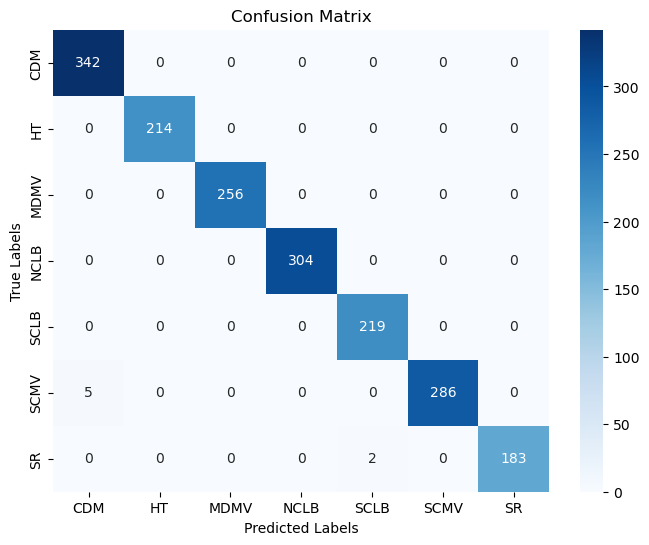

In [54]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Assuming class_names, true_labels_class, and all_predicted_classes_thresholded are already defined

# Calculate the confusion matrix
cm = confusion_matrix(true_labels_class, all_predicted_classes_thresholded, labels=class_names)

# Convert confusion matrix to DataFrame for better readability
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Calculate Precision and Recall for each class
precision = precision_score(true_labels_class, all_predicted_classes_thresholded, average=None, labels=class_names)
recall = recall_score(true_labels_class, all_predicted_classes_thresholded, average=None, labels=class_names)

# Calculate F1-Score for each class
f1 = f1_score(true_labels_class, all_predicted_classes_thresholded, average=None, labels=class_names)

# Create a DataFrame to show precision, recall, and f1-score
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}, index=class_names)

# Print confusion matrix and metrics
print("Confusion Matrix:\n")
print(cm_df)

print("\nPrecision, Recall, and F1-Score for each class:\n")
print(metrics_df)

# Optionally, calculate average precision, recall, and F1-Score
average_precision = precision_score(true_labels_class, all_predicted_classes_thresholded, average='macro')
average_recall = recall_score(true_labels_class, all_predicted_classes_thresholded, average='macro')
average_f1 = f1_score(true_labels_class, all_predicted_classes_thresholded, average='macro')

# Calculate mean and standard deviation for Precision, Recall, and F1-Score
mean_precision = np.mean(precision)
mean_recall = np.mean(recall)
mean_f1 = np.mean(f1)

std_precision = np.std(precision)
std_recall = np.std(recall)
std_f1 = np.std(f1)

# Print the averages, means, and standard deviations
print(f"\nAverage Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")
print(f"Average F1-Score: {average_f1:.4f}")

print(f"\nMean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f}")

print(f"\nStandard Deviation of Precision: {std_precision:.4f}")
print(f"Standard Deviation of Recall: {std_recall:.4f}")
print(f"Standard Deviation of F1-Score: {std_f1:.4f}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Confusion Matrix:

      CDM   HT  MDMV  NCLB  SCLB  SCMV   SR
CDM   342    0     0     0     0     0    0
HT      0  214     0     0     0     0    0
MDMV    0    0   256     0     0     0    0
NCLB    0    0     0   304     0     0    0
SCLB    0    0     0     0   219     0    0
SCMV    5    0     0     0     0   286    0
SR      0    0     0     0     2     0  183

Precision, Recall, and F1-Score for each class:

      Precision    Recall  F1-Score
CDM    0.985591  1.000000  0.992743
HT     1.000000  1.000000  1.000000
MDMV   1.000000  1.000000  1.000000
NCLB   1.000000  1.000000  1.000000
SCLB   0.990950  1.000000  0.995455
SCMV   1.000000  0.982818  0.991334
SR     1.000000  0.989189  0.994565

Average Precision: 0.9966
Average Recall: 0.9960
Average F1-Score: 0.9963

Mean Precision: 0.9966
Mean Recall: 0.9960
Mean F1-Score: 0.9963

Standard Deviation of Precision: 0.0055
Standard Deviation of Recall: 0.0065
Standard Deviation of F1-Score: 0.0034


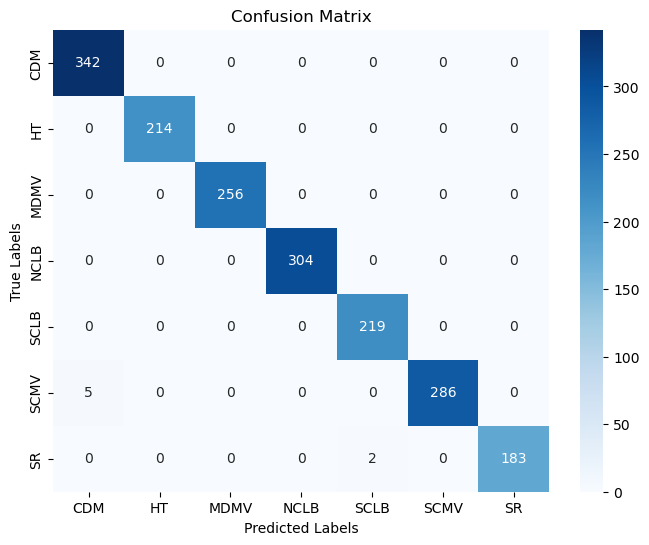

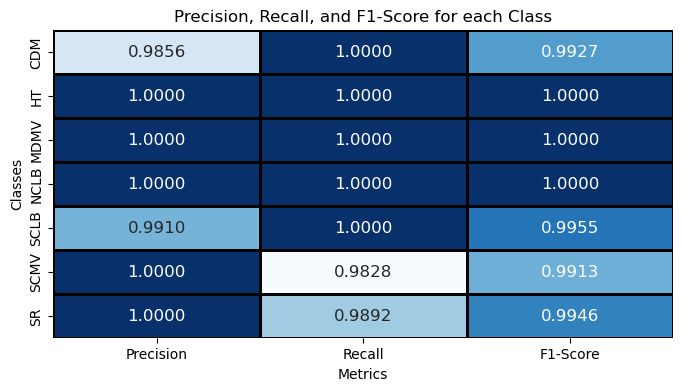

In [55]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Assuming class_names, true_labels_class, and all_predicted_classes_thresholded are already defined

# Calculate the confusion matrix
cm = confusion_matrix(true_labels_class, all_predicted_classes_thresholded, labels=class_names)

# Convert confusion matrix to DataFrame for better readability
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Calculate Precision and Recall for each class
precision = precision_score(true_labels_class, all_predicted_classes_thresholded, average=None, labels=class_names)
recall = recall_score(true_labels_class, all_predicted_classes_thresholded, average=None, labels=class_names)

# Calculate F1-Score for each class
f1 = f1_score(true_labels_class, all_predicted_classes_thresholded, average=None, labels=class_names)

# Create a DataFrame to show precision, recall, and f1-score
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}, index=class_names)

# Print confusion matrix and metrics
print("Confusion Matrix:\n")
print(cm_df)

print("\nPrecision, Recall, and F1-Score for each class:\n")
print(metrics_df)

# Optionally, calculate average precision, recall, and F1-Score
average_precision = precision_score(true_labels_class, all_predicted_classes_thresholded, average='macro')
average_recall = recall_score(true_labels_class, all_predicted_classes_thresholded, average='macro')
average_f1 = f1_score(true_labels_class, all_predicted_classes_thresholded, average='macro')

# Calculate mean and standard deviation for Precision, Recall, and F1-Score
mean_precision = np.mean(precision)
mean_recall = np.mean(recall)
mean_f1 = np.mean(f1)

std_precision = np.std(precision)
std_recall = np.std(recall)
std_f1 = np.std(f1)

# Print the averages, means, and standard deviations
print(f"\nAverage Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")
print(f"Average F1-Score: {average_f1:.4f}")

print(f"\nMean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f}")

print(f"\nStandard Deviation of Precision: {std_precision:.4f}")
print(f"Standard Deviation of Recall: {std_recall:.4f}")
print(f"Standard Deviation of F1-Score: {std_f1:.4f}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plotting the metrics table as a heatmap (similar to confusion matrix)
plt.figure(figsize=(8, 4))  # Adjust the figure size as needed

# Use seaborn heatmap to display the metrics table as a styled heatmap
sns.heatmap(metrics_df, annot=True, fmt='.4f', cmap='Blues', cbar=False, annot_kws={"size": 12}, 
            xticklabels=metrics_df.columns, yticklabels=metrics_df.index, linewidths=1, linecolor='black')

# Customize the table appearance
plt.title("Precision, Recall, and F1-Score for each Class")
plt.xlabel('Metrics')
plt.ylabel('Classes')

# Show the plot
plt.show()